# Lab 3: final challenges

__Вам предлагается решить задачу классификации сигналов (вы уже встречались с ней во второй лабораторной работе) или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


In [0]:
import time

import natsort

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

from sklearn.metrics import accuracy_score

from PIL import Image

import torch
import torch.nn as nn
from torch import utils

import torchvision
from torchvision import transforms
from torchvision import models

import torchsummary

from IPython import display

import matplotlib
matplotlib.rcParams.update({'font.size':14})

%matplotlib inline

In [4]:
def LOG(text):
    print(text)
    print('-'*70)

try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    LOG("""Don't forget to avoid disconnections:
function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    """)

WORK_DIR = './'
if USE_COLAB:
    from google.colab import files, drive
    WORK_DIR = '/content/drive/'
    drive.mount(WORK_DIR)
    WORK_DIR += 'My Drive/projects/lab-3-dogs/'
LOG(f"Working directory is {WORK_DIR}")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
LOG(f'Using device is {device}')

Don't forget to avoid disconnections:
function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    
----------------------------------------------------------------------
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Working directory is /content/drive/My Drive/projects/lab-3-dogs/
----------------------------------------------------------------------
Using device is cuda:0
----------------------------------------

## Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [0]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [0]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [0]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [0]:
# Your experiments here

## Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

### Загрузка данных

#### Извлечём изображения

In [5]:
file_name = WORK_DIR + "data.zip"
!unzip "$file_name" > /dev/null
!ls data/
data_path = 'data/'

test  train


#### Изучим размеры картинок

In [0]:
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')
widths = []
heights = []

for target_folder in os.listdir(train_dir):
    target_dir = os.path.join(train_dir, target_folder)
    for image_name in os.listdir(target_dir):
        image_path = os.path.join(target_dir, image_name)
        image = Image.open(image_path)
        widths.append(image.width)
        heights.append(image.height)
widths = np.array(widths)
heights = np.array(heights)

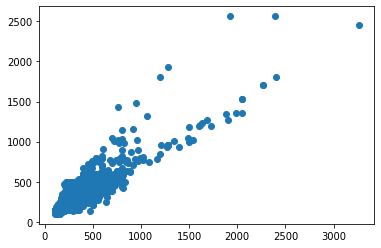

In [7]:
plt.figure()
plt.scatter(widths, heights)
plt.show()

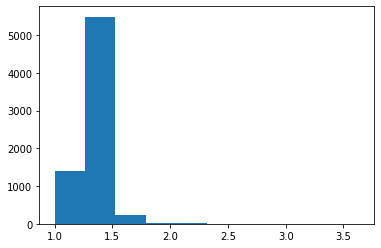

In [8]:
plt.figure()
plt.hist(np.max(np.vstack([widths, heights]), axis=0) / np.min(np.vstack([widths, heights]), axis=0))
plt.show()

#### **Выводы**

Можно заметить, что исходные фотографии различных размеров, причём число тех, у которых высота больше ширины, примерно столько же как и тех, у которых ширина больше высоты. Поэтому наша будущая модель будет принимать квадратное изображение. Размер будет $224 \times 224$

#### Загрузим тестовые данные, а так же поделим их на train/validate

In [9]:
full_train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])
)

n = len(full_train_dataset)
train_size = int(n*0.8)
validate_size = n - train_size
train_dataset, validate_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, validate_size])
validate_dataset.dataset.transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])
print(f'Length of train dataset is {len(train_dataset)}, should be {train_size}')
print(f'Length of validate dataset is {len(validate_dataset)}, should be {validate_size}')

full_train_loader = torch.utils.data.DataLoader(
    full_train_dataset,
    batch_size=128,
    num_workers=0,
    shuffle=True
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    num_workers=0,
    shuffle=True
)
validate_loader = torch.utils.data.DataLoader(
    validate_dataset,
    batch_size=128,
    num_workers=0,
    shuffle=True
)

Length of train dataset is 5732, should be 5732
Length of validate dataset is 1434, should be 1434


#### Объявим test_dataset и test_dataloader

In [0]:
class ImageSingleFolder(utils.data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [0]:
test_dataset = ImageSingleFolder(
    main_dir=test_dir,
    transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=True
)

### Определим нейронную сеть

#### Загрузка VGG16

In [0]:
def get_vgg16net(num_classes):
    net = models.vgg16(pretrained=True)
    net.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(4096, num_classes),
    )
    return net

#### Загрузка ResNet18

In [0]:
def get_resnet18(num_classes):
    net = models.resnet18(pretrained=True)
    num_ftrs = net.fc.in_features

    net.fc = nn.Linear(num_ftrs, num_classes)
    return net

#### Загрузка ResNet34

In [0]:
def get_resnet34(num_classes):
    net = models.resnet34(pretrained=True)
    num_ftrs = net.fc.in_features

    net.fc = nn.Linear(num_ftrs, num_classes)
    return net

#### Класс для обучения

In [0]:
class LearningModel:
    def __init__(self, net, net_name):
        self.net = net
        self.net_name = net_name
        self.optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
        self.criterion = nn.CrossEntropyLoss()
        self.epoch = 0
        self.metrics = {'accuracy' : {}, 'loss' : {}}
    
    def predict(self, input):
        return self.net.forward(input).argmax(axis=-1)
    
    def get_acc(self, img_batch, label_batch):
        predictions = self.predict(img_batch)
        return (predictions == label_batch).float().mean()

    def get_loss(self, img_batch, label_batch):
        predictions = self.net.forward(img_batch)
        loss = self.criterion(predictions, label_batch)
        return loss

    def evaluate(self, data_loaders):
        with torch.no_grad():
            for name, data_loader in data_loaders.items():
                metrics_sum = {'accuracy':0., 'loss':0.}
                metrics_func = {'accuracy':self.get_acc, 'loss':self.get_loss}
                total_num = 0.
                for img_batch, label_batch in data_loader:
                    batch_size = img_batch.shape[0]
                    img_batch = img_batch.to(device)
                    label_batch = label_batch.to(device)
                    
                    for k in metrics_sum.keys():
                        metrics_sum[k] += metrics_func[k](img_batch, label_batch) * batch_size
                    
                    total_num += batch_size
                
                for k, v in metrics_sum.items():
                    self.metrics[k].setdefault(name, [])
                    self.metrics[k][name].append(v / total_num)


    def fit(self,
            data_loaders,
            n_epoch=20,
           ):
        self.n_epoch = n_epoch

        while self.epoch <= n_epoch:
            display.clear_output(wait=True)
            self.evaluate(data_loaders)
            self.visualize()
            if self.epoch == n_epoch:
                break

            for img_batch, label_batch in data_loaders['train']:
                img_batch = img_batch.to(device)
                label_batch = label_batch.to(device)

                self.optimizer.zero_grad()
                
                loss = self.get_loss(img_batch, label_batch)
            
                # Backward
                loss.backward()
                
                # Update weights
                self.optimizer.step()
            
            self.epoch += 1

        return self
    
    def visualize_metric(self, ax, metric_name):
        ax.set_title(metric_name)
        ax.set_xlabel('Epoch num')
        ax.set_ylabel(metric_name)

        for k, v in self.metrics[metric_name].items():
            ax.plot(v, label=f'On {k} {metric_name}={v[-1]}')
        
        ax.legend(loc='best')

    def visualize(self, independ_plot=False):
        print('Epoch {}/{}'.format(self.epoch, self.n_epoch))

        fig = plt.figure(figsize=(29.7/2, 21.))

        loss_ax = fig.add_subplot(2, 1, 1)
        acc_ax = fig.add_subplot(2, 1, 2)

        self.visualize_metric(loss_ax, 'loss')
        self.visualize_metric(acc_ax, 'accuracy')
        
        plt.legend(loc='best')
        plt.show()

### Эксперименты с обучением
Для начала выясним при каком числе итерация начинается переобучение

#### Будем обучать ResNet18 на 80% тренировочной выборке, а валидироваться на 20%

In [42]:
resnet18 = get_resnet18(50).to(device)
torchsummary.summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch 0/70


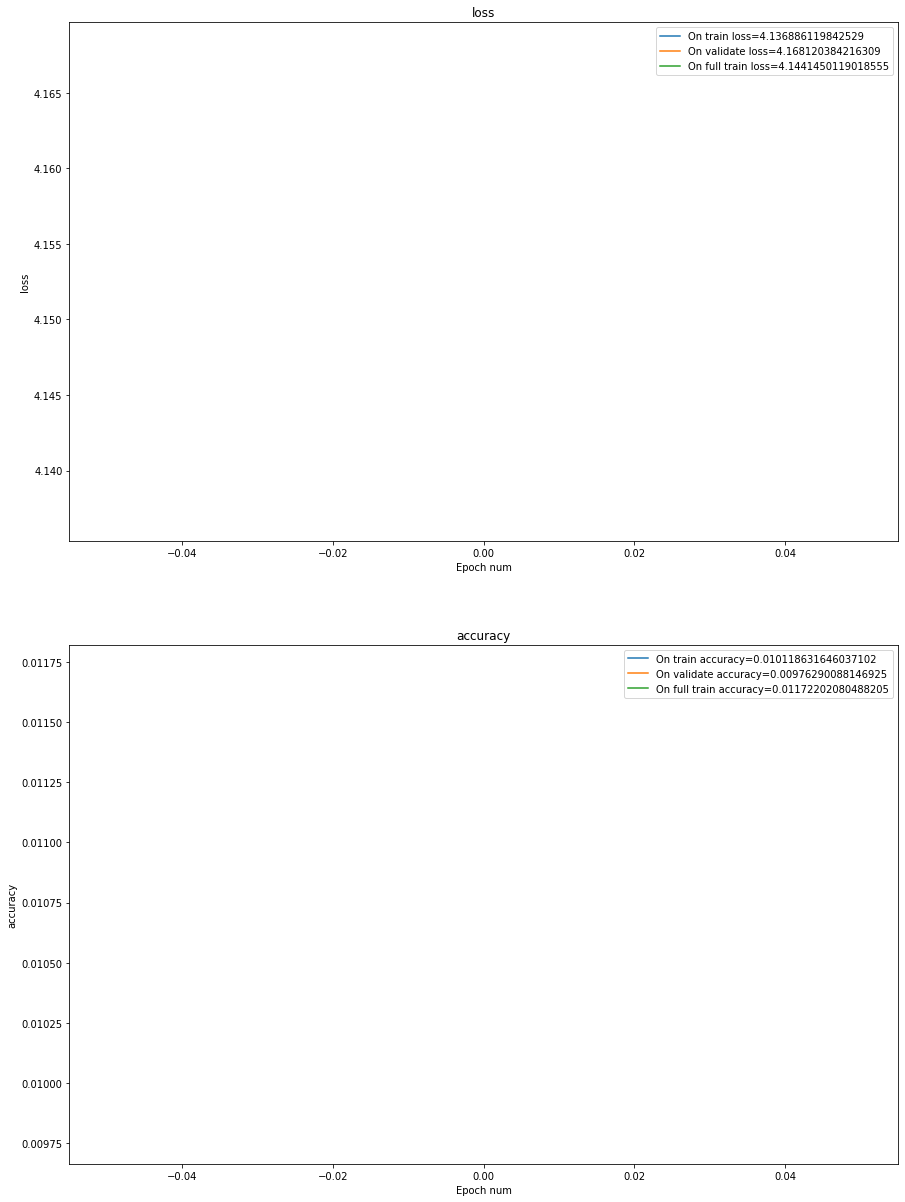

In [0]:
%%time
resnet18_lm = LearningModel(resnet18, 'ResNet18')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader,
    'full train' : full_train_loader
}
resnet18_lm.fit(dataloaders, n_epoch=70)

#### Попробуем ResNet34

In [0]:
resnet34 = get_resnet34(50).to(device)
torchsummary.summary(resnet34, (3, 224, 224))

In [0]:
%%time
resnet34_lm = LearningModel(resnet34, 'ResNet34')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader,
    'full train' : full_train_loader
}
resnet34_lm.fit(dataloaders, n_epoch=50)

#### Теперь попытаем удачу с VGG16

In [16]:
vggnet = get_vgg16net(50).to(device)
torchsummary.summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [17]:
vggnet_lm = LearningModel(vggnet, 'VggNet16')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader,
    'full train' : full_train_loader
}
vggnet_lm.fit(dataloaders, n_epoch=7)

KeyboardInterrupt: ignored